In [2]:
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Activation, Conv1D, MaxPooling1D,LeakyReLU, Dropout, LSTM, Bidirectional, GRU, BatchNormalization, ELU, Attention, LSTM, Input, UpSampling1D, TimeDistributed, SpatialDropout2D, SpatialDropout1D, concatenate
from tensorflow.keras.optimizers import SGD

plt.style.use('seaborn-poster')
%matplotlib inline

In [6]:
dir = './data/trainAlunos/'
list_npy_files = glob.glob(dir + '*.npy')
fnames_dataset_train = tf.data.Dataset.from_tensor_slices(list_npy_files)

In [7]:
dir = './data/validacaoAlunos/'
list_npy_files = glob.glob(dir + '*.npy')
fnames_dataset_validacao = tf.data.Dataset.from_tensor_slices(list_npy_files)

In [8]:
dir = './data/testeAlunos/'
list_npy_files = glob.glob(dir + '*.npy')
fnames_dataset_test = tf.data.Dataset.from_tensor_slices(list_npy_files)

In [9]:
def read_npy(fname):
    """fname should be a npy file"""
    fname = fname.decode()
    recData = np.load(fname)
    return recData.astype(np.float32)

In [10]:
dataset_raw_train = fnames_dataset_train.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
dataset_raw_validacao = fnames_dataset_validacao.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
dataset_raw_test = fnames_dataset_test.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))

In [7]:
""" min= 5000
for i in iter(dataset_raw_train):
    #print(i[0].shape[1])
    if i[0].shape[1] < min:
        min = i[0].shape[1]
    #break
    
min """

' min= 5000\nfor i in iter(dataset_raw_train):\n    #print(i[0].shape[1])\n    if i[0].shape[1] < min:\n        min = i[0].shape[1]\n    #break\n    \nmin '

## Static Sizes

In [8]:
dataset_cuted_train = dataset_raw_train.map(lambda x: x[:,(tf.shape(x)[1]-2000):tf.shape(x)[1]])
dataset_cuted_validacao = dataset_raw_validacao.map(lambda x: x[:,(tf.shape(x)[1]-2000):tf.shape(x)[1]])
dataset_cuted_test = dataset_raw_test.map(lambda x: x[:,(tf.shape(x)[1]-2000):tf.shape(x)[1]])

In [9]:
""" it3 = iter(dataset_cuted_train)
ex3 = next(it3)
ex3.shape """

' it3 = iter(dataset_cuted_train)\nex3 = next(it3)\nex3.shape '

In [10]:
frame_length= 1000
frame_step = 10

def stft(x):
    return tf.signal.stft(
    x,
    frame_length,
    frame_step,
    fft_length=None,
    window_fn=tf.signal.hann_window,
    pad_end=False,
    name=None
)

In [11]:
dataset2x_train = dataset_cuted_train.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 256, frame_step = 128)), x[1]))
dataset2x_validacao = dataset_cuted_validacao.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 256, frame_step = 128)), x[1]))
dataset2x_test = dataset_cuted_test.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 256, frame_step = 128)), x[1]))

In [12]:
it3 = iter(dataset2x_train)
ex3 = next(it3)
ex3

(<tf.Tensor: shape=(14, 129), dtype=float32, numpy=
 array([[4.0799033e+03, 1.2272309e+04, 7.2162002e+03, ..., 1.3904767e+02,
         2.7887966e+01, 1.8205566e+01],
        [4.2699473e+03, 1.2871683e+04, 1.0095986e+04, ..., 4.6013741e+01,
         1.1352508e+02, 6.6249756e+01],
        [4.5610225e+03, 7.2023442e+03, 1.5412860e+04, ..., 4.9293308e+01,
         8.5428505e+01, 2.5179688e+01],
        ...,
        [6.9241626e+03, 8.8304102e+03, 2.1321293e+04, ..., 8.2463585e+01,
         6.7195831e+01, 4.9052734e+01],
        [1.7521475e+04, 5.6102633e+04, 7.5388734e+04, ..., 1.1511120e+01,
         7.8482269e+01, 9.6849609e+01],
        [1.3976577e+03, 9.1582391e+04, 2.6074452e+05, ..., 9.0046486e+01,
         9.5586662e+01, 3.4563965e+01]], dtype=float32)>,
 <tf.Tensor: shape=(2000,), dtype=float32, numpy=array([4., 4., 4., ..., 3., 3., 3.], dtype=float32)>)

In [23]:
batch_size = 10

dataset_b_train = dataset2x_train.batch(batch_size)
dataset_b_validacao = dataset2x_validacao.batch(batch_size)
dataset_b_test = dataset2x_test.batch(batch_size)

NameError: name 'dataset2x_train' is not defined

In [14]:
""" it3 = iter(dataset_b_train)
ex3 = next(it3)
ex3 """

' it3 = iter(dataset_b_train)\nex3 = next(it3)\nex3 '

##########################################################################################################

In [16]:
modelFF = Sequential()
modelFF.add(keras.Input(shape=(14,129)))
modelFF.add(Flatten())
modelFF.add(Dense(512))
modelFF.add(Activation("relu"))
modelFF.add(BatchNormalization()) 
modelFF.add(Dropout(0.25))
modelFF.add(Dense(512))
modelFF.add(Activation("relu"))
modelFF.add(BatchNormalization())
modelFF.add(Dropout(0.5))
modelFF.add(Dense(5*2000))
modelFF.add(Reshape((2000,5)))
modelFF.add(Activation(activation="softmax"))


In [17]:
EPOCHS = 10
print("[INFO] training network...")
modelFF.compile(loss="sparse_categorical_crossentropy", optimizer='adam',
	metrics=["sparse_categorical_accuracy"])
H = modelFF.fit(dataset_b_train, validation_data=dataset_b_validacao, batch_size=batch_size, epochs=EPOCHS )

[INFO] training network...
Epoch 1/10
105/250 [===========>..................] - ETA: 30s - loss: 1.2266 - sparse_categorical_accuracy: 0.5472

: 

: 

In [ ]:
E = modelFF.evaluate(dataset_b_test)

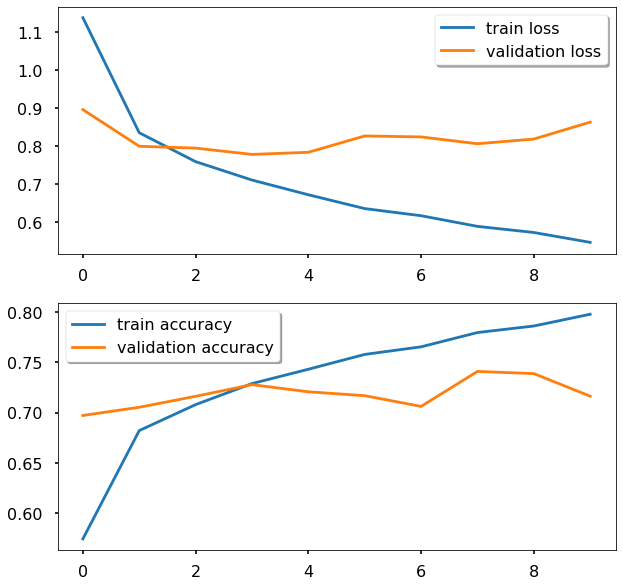

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(H.history["loss"], label="train loss")
ax[0].plot(H.history["val_loss"], label="validation loss")
legend=ax[0].legend(loc='best', shadow=True)

ax[1].plot(H.history["sparse_categorical_accuracy"], label="train accuracy")
ax[1].plot(H.history["val_sparse_categorical_accuracy"], label="validation accuracy")
legend=ax[1].legend(loc='best', shadow=True)

import time

current_time = time.time()
local_time = time.ctime(current_time)
month= local_time.split(' ')[1]
day= local_time.split(' ')[2]
hour= local_time.split(' ')[3].split(':')[0]
minute= local_time.split(' ')[3].split(':')[1]

plt.savefig('versions/feed_forward_'+str(month)+'_'+str(day)+'_'+str(hour)+'_'+str(minute)+'.png')



## Dynamic cut


In [24]:
dataset_dynamic_train = dataset_raw_train.map(lambda x: ((tf.shape(x)[1],tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 256, frame_step = 128))),x[1]))
dataset_dynamic_validacao = dataset_raw_validacao.map(lambda x: ((tf.shape(x)[1],tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 256, frame_step = 128))),x[1]))
dataset_dynamic_test = dataset_raw_test.map(lambda x: ((tf.shape(x)[1],tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 256, frame_step = 128))),x[1]))

In [25]:
""" it3 = iter(dataset_dynamic_train)
ex3 = next(it3)
ex3 """

' it3 = iter(dataset_dynamic_train)\nex3 = next(it3)\nex3 '

In [166]:
batch_size = 10
k=129
dataset_pb_train = dataset_dynamic_train.padded_batch(batch_size, padded_shapes=(([], tf.TensorShape([None, k])),[None]))
dataset_pb_validacao = dataset_dynamic_validacao.padded_batch(batch_size, padded_shapes=(([], tf.TensorShape([None, k])),[None]))
dataset_pb_test = dataset_dynamic_test.padded_batch(batch_size, padded_shapes=(([], tf.TensorShape([None, k])),[None]))

In [ ]:
""" it3 = iter(dataset_pb_train)
ex3 = next(it3)
ex3 """

## Conv


In [133]:
inputA= Input(shape=(None, 129), name="inputA")
inputB = Input(shape=[], name="inputB")
layer= Conv1D(filters=1024, kernel_size=2, padding="same")(inputA)
layer= Activation(activation="relu")(layer)
layer= BatchNormalization()(layer)
#layer= SpatialDropout1D(rate=0.2)(layer)
layer = TimeDistributed(Dense(50, activation="relu"))(layer)
layer= Activation(activation="softmax")(layer)
layer= Reshape((-1,5))(layer)
layer= UpSampling1D(size=15)(layer)
L= tf.cast(tf.reduce_max(inputB), tf.int32)
print(layer)
print(L.shape)
output= layer[:,:L]

modelConv = Model(inputs=(inputB, inputA), outputs=output)


KerasTensor(type_spec=TensorSpec(shape=(None, None, 5), dtype=tf.float32, name=None), name='up_sampling1d_37/Reshape:0', description="created by layer 'up_sampling1d_37'")
()


In [131]:
""" o = modelConv(ex3[0])
print(o.shape)
print(ex3[1].shape) """

' o = modelConv(ex3[0])\nprint(o.shape)\nprint(ex3[1].shape) '

In [134]:
EPOCHS = 10
opt = SGD(learning_rate=0.01, momentum=0.9) #TODO adam and no spatial dropout
metrics= [tf.keras.metrics.SparseCategoricalAccuracy()]
print("[INFO] training network...")
modelConv.compile(loss="sparse_categorical_crossentropy", optimizer='adam',
	metrics=metrics)
H = modelConv.fit(dataset_pb_train,validation_data=dataset_pb_validacao, batch_size=batch_size, epochs=EPOCHS )


[INFO] training network...
Epoch 1/10
250/250 [==============================] - 63s 250ms/step - loss: 1.2831 - sparse_categorical_accuracy: 0.4213 - val_loss: 1.2491 - val_sparse_categorical_accuracy: 0.4765
Epoch 2/10
250/250 [==============================] - 67s 268ms/step - loss: 1.1861 - sparse_categorical_accuracy: 0.4773 - val_loss: 1.3382 - val_sparse_categorical_accuracy: 0.4875
Epoch 3/10
250/250 [==============================] - 66s 263ms/step - loss: 1.1692 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.3806 - val_sparse_categorical_accuracy: 0.4952
Epoch 4/10
250/250 [==============================] - 64s 256ms/step - loss: 1.1630 - sparse_categorical_accuracy: 0.4979 - val_loss: 1.3830 - val_sparse_categorical_accuracy: 0.5007
Epoch 5/10
250/250 [==============================] - 63s 252ms/step - loss: 1.1598 - sparse_categorical_accuracy: 0.5005 - val_loss: 1.2975 - val_sparse_categorical_accuracy: 0.5038
Epoch 6/10
250/250 [==============================] - 60s 

In [135]:
E = modelConv.evaluate(dataset_pb_test)

29/29 [==============================] - 3s 84ms/step - loss: 1.1112 - sparse_categorical_accuracy: 0.5304


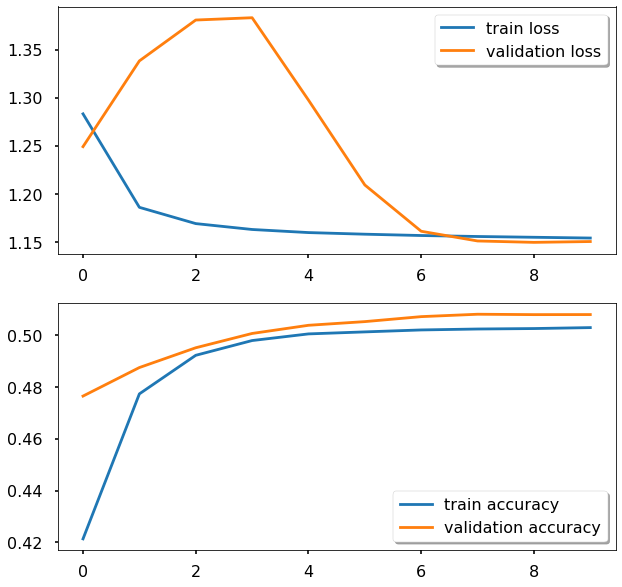

In [136]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(H.history["loss"], label="train loss")
ax[0].plot(H.history["val_loss"], label="validation loss")
legend=ax[0].legend(loc='best', shadow=True)

ax[1].plot(H.history["sparse_categorical_accuracy"], label="train accuracy")
ax[1].plot(H.history["val_sparse_categorical_accuracy"], label="validation accuracy")
legend=ax[1].legend(loc='best', shadow=True)

import time

current_time = time.time()
local_time = time.ctime(current_time)
month= local_time.split(' ')[1]
day= local_time.split(' ')[2]
hour= local_time.split(' ')[3].split(':')[0]
minute= local_time.split(' ')[3].split(':')[1]

plt.savefig('versions/convolutional_'+str(month)+'_'+str(day)+'_'+str(hour)+'_'+str(minute)+'.png')


## Rec


In [167]:
inputA= Input(shape=(None, 129), name="inputA")
inputB = Input(shape=[], name="inputB")
layer= Conv1D(filters=256, kernel_size=2, padding="same")(inputA)
layer= Activation(activation="relu")(layer)
layer= BatchNormalization()(layer)
layer= LSTM(units=100, return_sequences=True)(layer)
layer = LeakyReLU(alpha=0.1)(layer)
layer= BatchNormalization()(layer)
layer = TimeDistributed(Dense(50, activation="relu"))(layer)
layer= Activation(activation="softmax")(layer)
layer= Reshape((-1,5))(layer)
layer= UpSampling1D(size=15)(layer)
L= tf.cast(tf.reduce_max(inputB), tf.int32)
print(layer)
print(L.shape)
output= layer[:,:L]

modelConv = Model(inputs=(inputB, inputA), outputs=output)

L= tf.cast(tf.reduce_max(inputB), tf.int32)
print(layer)
print(L.shape)
output= layer[:,:L]

modelRec = Model(inputs=(inputB, inputA), outputs=output)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 5), dtype=tf.float32, name=None), name='up_sampling1d_52/Reshape:0', description="created by layer 'up_sampling1d_52'")
()
KerasTensor(type_spec=TensorSpec(shape=(None, None, 5), dtype=tf.float32, name=None), name='up_sampling1d_52/Reshape:0', description="created by layer 'up_sampling1d_52'")
()


In [168]:
EPOCHS = 25 #TODO 25
opt = SGD(learning_rate=0.01, momentum=0.9)
metrics= [tf.keras.metrics.SparseCategoricalAccuracy()]
print("[INFO] training network...")
modelRec.compile(loss="sparse_categorical_crossentropy", optimizer='adam',
	metrics=metrics)
H = modelRec.fit(dataset_pb_train,validation_data=dataset_pb_validacao, batch_size=batch_size, epochs=EPOCHS )

[INFO] training network...
Epoch 1/25
250/250 [==============================] - 119s 464ms/step - loss: 1.2432 - sparse_categorical_accuracy: 0.4625 - val_loss: 1.2229 - val_sparse_categorical_accuracy: 0.5023
Epoch 2/25
250/250 [==============================] - 117s 468ms/step - loss: 1.1624 - sparse_categorical_accuracy: 0.5067 - val_loss: 1.6514 - val_sparse_categorical_accuracy: 0.3082
Epoch 3/25
250/250 [==============================] - 117s 468ms/step - loss: 1.1676 - sparse_categorical_accuracy: 0.5061 - val_loss: 1.7339 - val_sparse_categorical_accuracy: 0.2891
Epoch 4/25
250/250 [==============================] - 115s 460ms/step - loss: 1.1314 - sparse_categorical_accuracy: 0.5186 - val_loss: 1.8891 - val_sparse_categorical_accuracy: 0.2921
Epoch 5/25
250/250 [==============================] - 116s 466ms/step - loss: 1.1040 - sparse_categorical_accuracy: 0.5245 - val_loss: 1.7511 - val_sparse_categorical_accuracy: 0.2901
Epoch 6/25
250/250 [==============================] -

In [169]:
E = modelRec.evaluate(dataset_pb_test)

29/29 [==============================] - 5s 166ms/step - loss: 0.8859 - sparse_categorical_accuracy: 0.6586


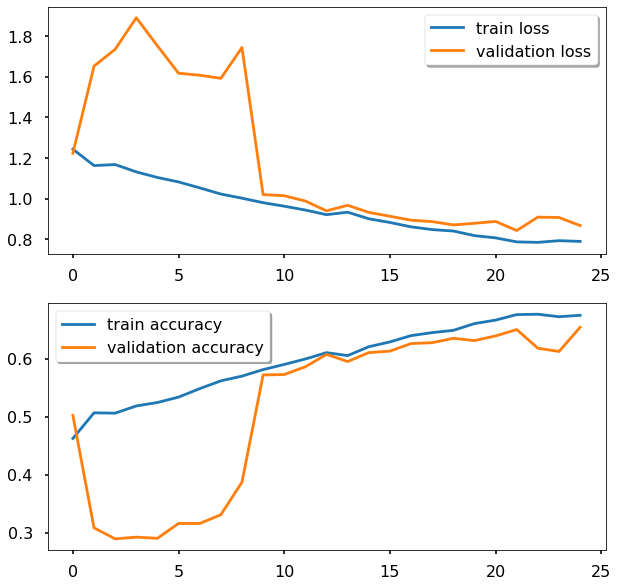

In [170]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(H.history["loss"], label="train loss")
ax[0].plot(H.history["val_loss"], label="validation loss")
legend=ax[0].legend(loc='best', shadow=True)

ax[1].plot(H.history["sparse_categorical_accuracy"], label="train accuracy")
ax[1].plot(H.history["val_sparse_categorical_accuracy"], label="validation accuracy")
legend=ax[1].legend(loc='best', shadow=True)

import time

current_time = time.time()
local_time = time.ctime(current_time)
month= local_time.split(' ')[1]
day= local_time.split(' ')[2]
hour= local_time.split(' ')[3].split(':')[0]
minute= local_time.split(' ')[3].split(':')[1]

plt.savefig('versions/recorrent_'+str(month)+'_'+str(day)+'_'+str(hour)+'_'+str(minute)+'.png')

## Transformer

In [17]:
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        batchS = tf.shape(x)[0]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        positions = tf.expand_dims(positions, axis = 0)
        positions = tf.repeat(positions, batchS, axis=0)
        return x + positions

In [18]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [171]:
inputA= Input(shape=(None, 129), name="inputA")
inputB = Input(shape=[], name="inputB")
layer= Conv1D(filters=256, kernel_size=2, padding="same")(inputA)
layer = LeakyReLU(alpha=0.1)(layer)
embDim = 100
newEmb = layers.TimeDistributed(layers.Dense(embDim))(layer)
inputsPosEmb = PositionEmbedding(maxlen=5000, embed_dim=embDim)(newEmb) 
transf1 = TransformerBlock(embed_dim=embDim,num_heads=3, ff_dim=8)(inputsPosEmb)
transf2 =TransformerBlock(embed_dim=embDim,num_heads=3, ff_dim=8)(transf1)
out = layers.TimeDistributed(layers.Dense(5))(transf2)
layer= Activation(activation="softmax")(out)
layer= Reshape((-1,5))(layer)
layer= UpSampling1D(size=150)(layer)
L= tf.cast(tf.reduce_max(inputB), tf.int32)
output= layer[:,:L]
modelTransf = keras.Model(inputs=(inputB, inputA), outputs=output)


In [162]:
""" o = modelTransf(ex3[0])
print(o.shape)
print(ex3[1].shape) """

' o = modelTransf(ex3[0])\nprint(o.shape)\nprint(ex3[1].shape) '

In [172]:
lr = 1.0e-4
metrics= [tf.keras.metrics.SparseCategoricalAccuracy()]
modelTransf.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics = metrics)
H= modelTransf.fit(dataset_pb_train, validation_data=dataset_pb_validacao,  batch_size=batch_size, epochs = 10)

Epoch 1/10
250/250 [==============================] - 163s 639ms/step - loss: 1.4135 - sparse_categorical_accuracy: 0.4835 - val_loss: 1.3867 - val_sparse_categorical_accuracy: 0.5084
Epoch 2/10
250/250 [==============================] - 151s 605ms/step - loss: 1.3904 - sparse_categorical_accuracy: 0.5055 - val_loss: 1.3868 - val_sparse_categorical_accuracy: 0.5083
Epoch 3/10
250/250 [==============================] - 146s 586ms/step - loss: 1.3898 - sparse_categorical_accuracy: 0.5058 - val_loss: 1.3875 - val_sparse_categorical_accuracy: 0.5084
Epoch 4/10
250/250 [==============================] - 146s 585ms/step - loss: 1.3895 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.3884 - val_sparse_categorical_accuracy: 0.5084
Epoch 5/10
250/250 [==============================] - 147s 590ms/step - loss: 1.3895 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.3871 - val_sparse_categorical_accuracy: 0.5084
Epoch 6/10
250/250 [==============================] - 148s 591ms/step - loss: 1.

In [127]:
E = modelTransf.evaluate(dataset_pb_test)

29/29 [==============================] - 4s 133ms/step - loss: 1.0914 - sparse_categorical_accuracy: 0.5295


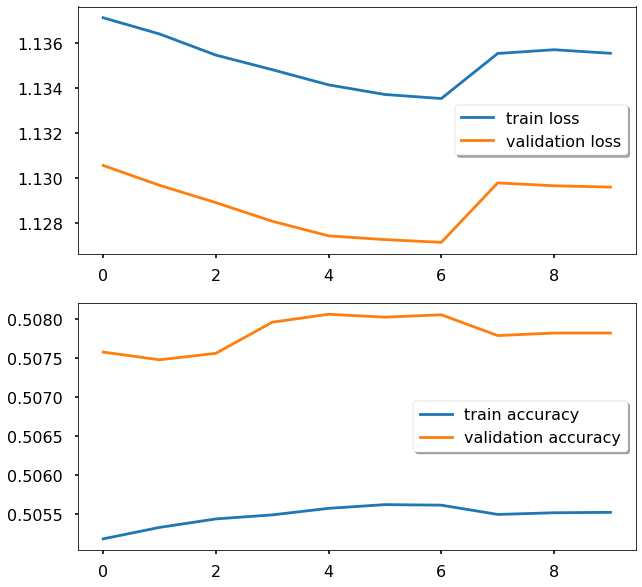

In [128]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(H.history["loss"], label="train loss")
ax[0].plot(H.history["val_loss"], label="validation loss")
legend=ax[0].legend(loc='best', shadow=True)

ax[1].plot(H.history["sparse_categorical_accuracy"], label="train accuracy")
ax[1].plot(H.history["val_sparse_categorical_accuracy"], label="validation accuracy")
legend=ax[1].legend(loc='best', shadow=True)

import time

current_time = time.time()
local_time = time.ctime(current_time)
month= local_time.split(' ')[1]
day= local_time.split(' ')[2]
hour= local_time.split(' ')[3].split(':')[0]
minute= local_time.split(' ')[3].split(':')[1]

plt.savefig('versions/transformer_'+str(month)+'_'+str(day)+'_'+str(hour)+'_'+str(minute)+'.png')